# Predicting Senate Midterm Elections

We will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a final prediction of the result of each state.

#### Data

We will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from StringIO import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import collections

In [2]:
# special matplotlib argument for improved plots
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data Wrangling

We will read in the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) and create a dictionary of DataFrames as well a master table information for each race.

In [3]:
### Your code here ###
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"
info = requests.get(url_str).json()
type(info)

list

First, we use a list comprehension to extract the `state` from each race. Then, we use the python module `collections.Counter` to determine which states have multiple races.

In [4]:
states = [str(election['state']) for election in info]
titles = [str(election['title']) for election in info]

countStates = collections.Counter(states)
print countStates

Counter({'NH': 2, 'OK': 2, 'SC': 2, 'DE': 1, 'WV': 1, 'HI': 1, 'WY': 1, 'NJ': 1, 'NM': 1, 'TX': 1, 'LA': 1, 'NC': 1, 'NE': 1, 'TN': 1, 'RI': 1, 'VA': 1, 'CO': 1, 'AK': 1, 'AR': 1, 'IL': 1, 'GA': 1, 'IA': 1, 'MA': 1, 'ID': 1, 'ME': 1, 'MN': 1, 'MI': 1, 'KS': 1, 'MT': 1, 'MS': 1, 'KY': 1, 'OR': 1, 'SD': 1})


In [5]:
twoPollIndex = [elem[0] for elem in countStates.most_common(4)]
twoPollIndex

['NH', 'OK', 'SC', 'DE']

We can print all the titles of each state with more than one race and use google to find out more information about each race. 

In [6]:
for state in twoPollIndex:
    ind = [i for i, x in enumerate(states) if x == state]
    for elem in ind:
        print "title: %s (index: %g)" % (titles[elem], elem)

title: 2014 New Hampshire Senate: Bass vs. Shaheen (index: 29)
title: 2014 New Hampshire Senate: Brown vs. Shaheen (index: 31)
title: 2014 Oklahoma Senate: Lankford vs. Johnson (index: 4)
title: 2014 Oklahoma Senate: Inhofe vs. Silverstein (index: 12)
title: 2014 South Carolina Senate: Scott vs. Dickerson (index: 13)
title: 2014 South Carolina Senate: Graham vs. Hutto (index: 14)
title: 2014 Delaware Senate: Wade vs. Coons (index: 0)


Using some [google-fu](http://www.urbandictionary.com/define.php?term=google-fu), we see the races in Oklahoma and South Carolina are special elections. In New Hampshire, we see Bass withdrew so we will take out this race from our `info` JSON object.  The index in the `info` list is 29. Therefore, we will remove these index. 

In [7]:
removeset = set([29])
infoClean = [v for i, v in enumerate(info) if i not in removeset]

We create a dictionary of pandas DataFrames called `polls` keyed by the name of the election (a string). Each value in the dictionary should contain the polls for one of the races.

In [8]:
election_urls = [election['url'] + '.csv' for election in infoClean]

To create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string), we use the following function `build_frame`. 

In [9]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [10]:
# Makes a dictionary of pandas DataFrames keyed on election string.
polls = dict((election['slug'], build_frame(election['url']+'.csv')) for election in infoClean)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


The `dfs` dictionary contains a set of key-value pairs where the `key` is string of the election and the value is a pandas DataFrame with the polls for one 2014 Senate race. We can print the first few keys of the `dfs` dictionary using `keys()`. 

In [11]:
polls.keys()[0:5]

[u'2014-kentucky-senate-mcconnell-vs-grimes',
 u'2014-montana-senate-daines-vs-curtis',
 u'2014-north-carolina-senate-tillis-vs-hagan',
 u'2014-tennessee-senate-alexander-vs-ball',
 u'2014-michigan-senate-land-vs-peters']

Now we create a master table information containing information about each race. Wr create a pandas DataFrame called `candidates` with rows containing information about each race. The `candidates` DataFrame should have the following columns: 

1. `State` = the state where the race is being held
2. `R` = name of republican candidate
3. `D` = name of non-republican candidate (Democrate or Independent) 
4. `incumbent` = R, D or NA

In [12]:
### Your code here ###
rows = []
for i,dt in enumerate(infoClean):
    x = dt['estimates'][0:2]
    if x:
        if not x[0]['last_name']:
            tmp = dt['url'].split('-')+['vs']
            j = tmp.index('vs')
            if j!=len(tmp)-1:
                R = tmp[j-1].capitalize()
                D = tmp[j+1].capitalize()
                incumbent = np.nan
                #if no data means race is decided
        else:
            tmp = [x[0]['party'],x[1]['party']]
            R = x[tmp.index('Rep')]['last_name']
            idx = [k for k in range(len(tmp)) if tmp[k]!='Rep'][0]
            D = x[idx]['last_name']
            tmp2 = [x[0]['incumbent'],x[1]['incumbent']]
            tmp2+=[True]
            incumbent = np.nan
            if tmp2.index(True)!=2:
                incumbent = tmp[tmp2.index(True)]
    rows.append((dt['state'], R, D, incumbent))
    
candidates = pd.DataFrame(rows, columns=["State", "R", "D", "incumbent"])
        
#remove second last name 
candidates.R = [candidate.split(' ')[-1] for candidate in candidates.R]
candidates

,State,R,D,incumbent
0,DE,Wade,Coons,Dem
1,MA,Herr,Markey,Dem
2,RI,Herr,Markey,Dem
3,MT,Daines,Curtis,NaN
4,OK,Lankford,Johnson,NaN
5,HI,Cavasso,Schatz,Dem
6,KS,Roberts,Orman,Rep
7,WY,Enzi,Hardy,Rep
8,TN,Alexander,Ball,Rep
9,ID,Risch,Mitchell,Rep


##### We want to compute a 99% confidence interval for each state. 

*Assume you have $M$ polls with sample sizes $n_1, \dots, n_M$. If the polls are independent, what is the average of the variances of each poll if the true proportion is $p$?*

*The variance of a single poll with sample $n_i$ is $Var(X_i) = \frac{p(1-p)}{n_i}$. Therefore, the average of the variances across $M$ polls is*

*$$ \frac{1}{M} \sum_{i=1}^M Var( {X}_i) = \frac{1}{M} p(1-p)(1/n_1 + \dots +1/n_M) $$*

##### We will compute the square root of these values for the republican candidates in each race. Then, compute the standard deviations of the observed poll results for each race. 

In [13]:
import datetime

def calc_sds(infoClean, polls):
    theo_sds = []
    obs_sds = []
    npolls = []
    for ii,election in enumerate(infoClean):
        #Note that the `polls` dictionary does not have a guaranteed ordering
        #because Python dictionaries are unordered object. For this reason, we
        #need to be careful and use the ordered `infoClean` object to make sure we
        #are correctly aligning the elements of `polls` and the rows in `candidates`.
        polls_key = election['slug']
        this_election = polls[polls_key]
            
        npoll = this_election.shape[0]

        #Use the candidates dataframe to find the name of the Republican in this race.
        #Use this to grab the column of polling results for this candidate.
        #Put poll results onto the proportion (not percentage) scale
        if candidates.R.ix[ii] in this_election.columns:
            p = this_election[candidates.R.ix[ii]]/100
            n = this_election["Number of Observations"]

            #Theoretical sd assumes a common value of p across all polls. Use the mean.
            p_mean = np.mean(p)
            theo_sd = np.sqrt(p_mean*(1-p_mean)*np.mean(1./n))

            #Observed sd is a simple calculation.
            obs_sd = np.std(p)

            theo_sds.append(theo_sd)
            obs_sds.append(obs_sd)
            npolls.append(npoll)

    return (theo_sds, obs_sds, npolls)

theo, obs, npolls = calc_sds(infoClean, polls)

##### We plot observed versus theoretical (average of the theoretical SDs) with the area of the point proportional to number of polls. How do these compare?

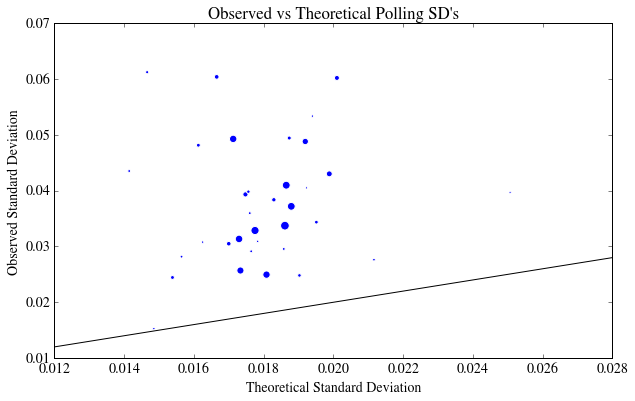

In [14]:
#Grab the poll count from the infoClean object.
plt.scatter(theo, obs, marker="o", s=npolls*10)
plt.xlabel("Theoretical Standard Deviation")
plt.ylabel("Observed Standard Deviation")
plt.title("Observed vs Theoretical Polling SD's")

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((0,1),(0,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

*Observed sd's are much larger than theoretical sd's. The overshoot is particularly large when there are large numbers of polls, suggesting that there is variation between pollsters that is not explained by the theoretical model.*

##### We create a scatter plot with each point representing one state. Is there one or more races that are outlier in that it they have much larger variabilities than expected? We explore the original poll data and explain why the discrepancy?

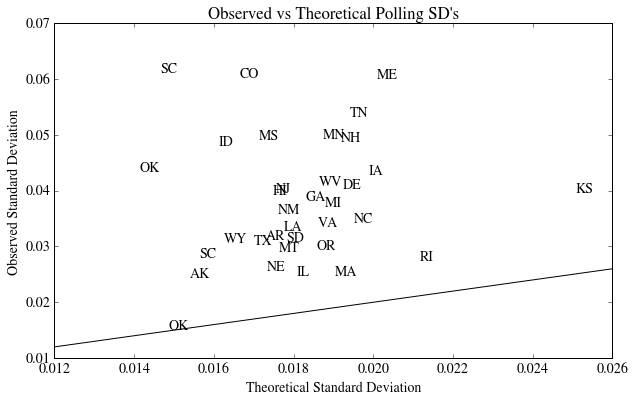

In [15]:
#This time, do the scatterplot using text labels on each datapoint.
plt.scatter(theo, obs, marker="o", s=0)
plt.xlabel("Theoretical Standard Deviation")
plt.ylabel("Observed Standard Deviation")
plt.title("Observed vs Theoretical Polling SD's")

for i in range(len(theo)):
    plt.text(theo[i], obs[i], candidates.ix[i,'State'])

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((0,1),(0,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

*South Carolina appears to be the biggest outlier.*

##### We construct confidence intervals for the difference in each race. We use either theoretical or data driven estimates of the standard error depending on our answer to this question. We use the results in last sections, to justify our choice.

Unsorted:
                                             race     lower     upper
0              2014-delaware-senate-wade-vs-coons -0.221629 -0.126371
1        2014-massachusetts-senate-herr-vs-markey -0.253322 -0.195908
2            2014-montana-senate-daines-vs-curtis  0.144632  0.198225
3        2014-oklahoma-senate-lankford-vs-johnson  0.266694  0.355806
4            2014-hawaii-senate-cavasso-vs-schatz -0.493233 -0.314267
5   2014-kansas-senate-roberts-vs-orman-vs-taylor -0.034860  0.063009
6                             2014-wyoming-senate  0.362462  0.533538
7         2014-tennessee-senate-alexander-vs-ball  0.144901  0.235099
8             2014-idaho-senate-risch-vs-mitchell  0.230231  0.366436
9           2014-new-jersey-senate-bell-vs-booker -0.164362 -0.110305
10            2014-new-mexico-senate-weh-vs-udall -0.182630 -0.109036
11     2014-oklahoma-senate-inhofe-vs-silverstein  0.268602  0.371398
12  2014-south-carolina-senate-scott-vs-dickerson  0.168389  0.261611
13     201

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


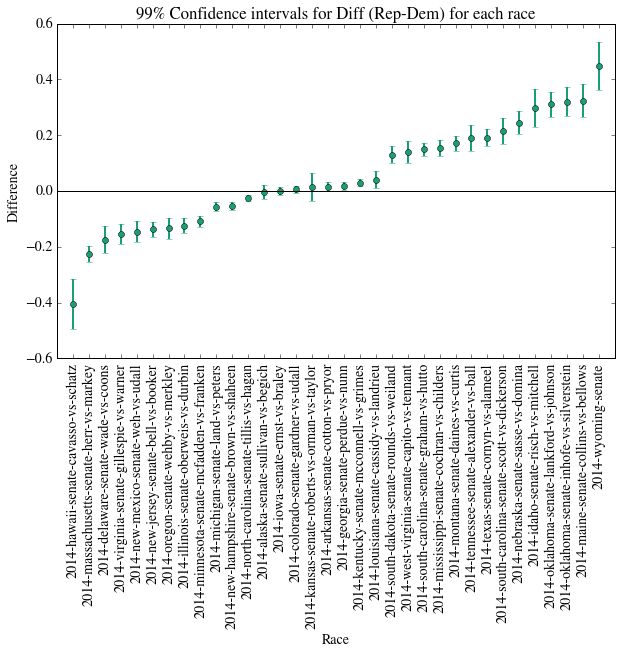

In [16]:
# this is mean +- 2.58 SD also save this results to candidate df for 99% confidence interval
def calc_diffs(infoClean, polls):
    rows = []
    for ii,election in enumerate(infoClean):
        #Note that the `polls` dictionary does not have a guaranteed ordering
        #because Python dictionaries are unordered object. For this reason, we
        #need to be careful and use the ordered `infoClean` object to make sure we
        #are correctly aligning the elements of `polls` and the rows in `candidates`.
        polls_key = election['slug']
        this_election = polls[polls_key]
            
        npoll = this_election.shape[0]

        #Use the candidates dataframe to find the name of the Republican in this race.
        #Use this to grab the column of polling results for this candidate.
        #Put poll results onto the proportion (not percentage) scale
        if candidates.R.ix[ii] in this_election.columns:
            diffs = (this_election[candidates.R.ix[ii]]-this_election[candidates.D.ix[ii]])/100

            mean_diff = np.mean(diffs)
            obs_se = np.std(diffs)/np.sqrt(npoll)

            rows.append((polls_key, mean_diff, obs_se, mean_diff-obs_se*2.58, mean_diff+obs_se*2.58))

    return rows

ests = pd.DataFrame(calc_diffs(infoClean, polls), columns=['race', 'mean', 'se', 'lower', 'upper'])
print "Unsorted:"
print ests[['race', 'lower', 'upper']]
ests.sort("mean", inplace=True)
print "Sorted:"
print ests[['race', 'lower', 'upper']]

plt.errorbar(range(ests.shape[0]), ests['mean'], yerr=ests['se']*2.58, fmt='o')
plt.xticks(range(ests.shape[0]), ests['race'].values, rotation=90)
plt.xlim(-1, ests.shape[0])
plt.axhline(0, linewidth=1, color='black')
plt.xlabel("Race")
plt.ylabel("Difference")
plt.title("99% Confidence intervals for Diff (Rep-Dem) for each race")
plt.show()

# Prediction and Posterior Probabilities

We perform a Bayesian analysis to predict the probability of Republicans winning in each state then provide a posterior distribution of the number of republicans in the senate.

#####  First, we define a Bayesian model for each race. The prior for the difference $\theta$ between republicans and democtrats will be $N(\mu,\tau^2)$. Say before seeing poll data you have no idea who is going to win, what should $\mu$ be? How about $\tau$, should it be large or small? 

*Because we have no prior idea who will win, the prior mean $\mu$ should be 0. And again we don't know anything about the data, but we know that the difference should not be very large. So $\tau$ should be small.*

#####  What is the distribution of $d$ conditioned on $\theta$. What is the posterior distribution of $\theta | d$? 

*$d \mid \theta \sim N(\theta, \sigma^2/M)$. We assume that $\sigma^2$ is known based on the observed sample variance, and $M$ is the number of polls averaged together to obtain $d$.*

*$\theta \mid d \sim N\left(B\mu + (1-B)d, (1-B)\sigma^2/M\right)$, where $B = \frac{1/\tau^2}{M/\sigma^2 + 1/\tau^2}$. (Note that there are lots of equivalent ways to write $B$, but this one shows that it is a *precision weight*, based on the ratio of the prior precision to the total precision of the prior and the data. Precision here is the inverse of the variance).*

*Equivalently, $\theta | d$ is $\theta | d \sim N( B \mu + (1-B) d, 1/(M/\sigma^2 + 1/ \tau^2))$.*

##### The prior represents what we think before hand. We do not know who is expected to win, so we assume $\mu=0$. For this problem we estimate $\tau$ using the observed differences across states (Hint: $\tau$ represents the standard deviation of a typical difference). We compute the posterior mean for each state and plot it against original average. Is there much change? Why or why not? 

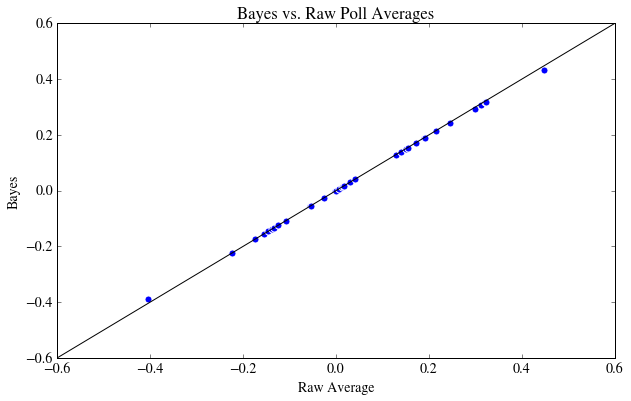

In [17]:
# A cheap but slightly biased way to estimate tau is to take the
# standard deviation of the state polling means.
# Use `ests` from last question.
tau = np.std(ests['mean'])
B = (1/tau**2)/(1/ests['se']**2+1/tau**2)
ests['mu_post'] = (1-B)*ests['mean']

plt.scatter(ests['mean'], ests['mu_post'], s=50)
plt.title("Bayes vs. Raw Poll Averages")
plt.xlabel("Raw Average")
plt.ylabel("Bayes")

currentx = plt.xlim()
currenty = plt.ylim()
plt.plot((-1,1),(-1,1), c='black', linewidth=1)
plt.xlim(currentx)
plt.ylim(currenty)
plt.show()

### Because there are a lot of datapoints (i.e. a lot of polls), $\sigma^2/M$ is much smaller than $\tau^2$, which results in a very small shrinkage factor for each datapoint (most elements of $B$ are extremely small). When you have this much data, the data largely overwhelms the prior. We do see that in those cases where the estimates are moved by the prior, they are pulled closer to zero than their raw average, resulting in a slope slightly shallower than 1.

##### For each state, we report a probabilty of Republicans winning. How does our answer here compare to the other aggregators?

In [18]:
#First, compute a standard deviation for each poll
ests['sd_post'] = np.sqrt((1-B)*ests['se']**2)

#Now, use normal CDF to find the posterior probability that the difference is greater than zero.
import scipy.stats
ests['R_win_prob'] = 1-scipy.stats.norm.cdf(0, loc=ests['mu_post'], scale=ests['sd_post'])
print ests[['race','R_win_prob']].sort('R_win_prob')

                                             race    R_win_prob
4            2014-hawaii-senate-cavasso-vs-schatz  0.000000e+00
1        2014-massachusetts-senate-herr-vs-markey  0.000000e+00
0              2014-delaware-senate-wade-vs-coons  0.000000e+00
26       2014-virginia-senate-gillespie-vs-warner  0.000000e+00
10            2014-new-mexico-senate-weh-vs-udall  0.000000e+00
9           2014-new-jersey-senate-bell-vs-booker  0.000000e+00
20            2014-oregon-senate-wehby-vs-merkley  0.000000e+00
24        2014-illinois-senate-oberweis-vs-durbin  0.000000e+00
15      2014-minnesota-senate-mcfadden-vs-franken  0.000000e+00
31            2014-michigan-senate-land-vs-peters  0.000000e+00
29     2014-new-hampshire-senate-brown-vs-shaheen  0.000000e+00
27     2014-north-carolina-senate-tillis-vs-hagan  6.413125e-09
23          2014-alaska-senate-sullivan-vs-begich  3.792437e-01
22               2014-iowa-senate-ernst-vs-braley  4.750937e-01
5   2014-kansas-senate-roberts-vs-orman-

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


*As expected from other aggregators, only a few states have outcomes that seem uncertain. Our model seems to be more certain about these tossup races than most aggregators. For us, the states that are less than 99% leaning one way or the other are IA, AK, CO, KS, LA, AR. Other aggregators also include NH, GA, and KY as being closer to tossups. Our model here does not seem to incorporate enough uncertainty (for example, the possibility that all of the polls in a given state might be clustered around the wrong value.*

##### We use the posterior distributions in a Monte Carlo simulation to generate election results. In each simulation we compute the total number of seats the Republican control and show a histogram of these results.

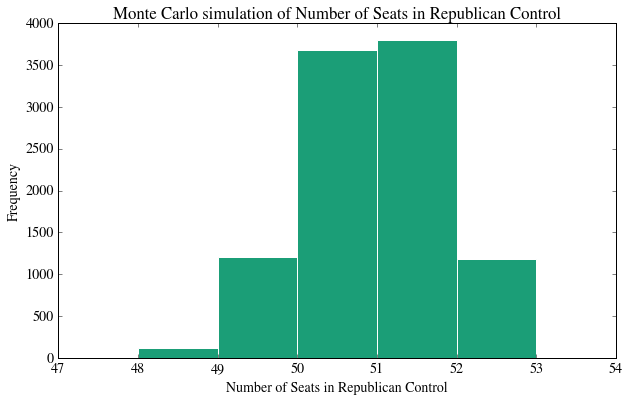

In [19]:
### made up numbers
num_states = ests.shape[0]

NSIM = 10000
simarr = np.zeros(NSIM, dtype=int)
for i in xrange(NSIM):
    simulated = 30 + np.sum(np.random.normal(ests['mu_post'], scale=ests['sd_post'], size =num_states) > 0 )
    simarr[i] = int(simulated)
plt.hist(simarr, bins=range(min(simarr)-1, max(simarr)+3))
plt.xlabel('Number of Seats in Republican Control')
plt.ylabel('Frequency')
plt.title('Monte Carlo simulation of Number of Seats in Republican Control')
plt.show()